# download mnist dataset
```bash load_mnist.sh```

In [1]:
import os
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RandomDataset(Dataset):

    def __init__(self, path, kind):
        # load data
        inputs, targets = load_mnist(path, kind=kind)
        self.len = inputs.shape[0]
        # normalize input values using min max scaler style
        x = torch.tensor(((inputs / 255.) - 0.5).reshape((-1, 28, 28)), dtype=torch.double)
        m = nn.ConstantPad2d(2, -0.5)
        self.x = m(x).unsqueeze(1).float()
        # one hot encoding labels
        self.y = torch.tensor(targets, dtype=torch.long)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1).float()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [4]:
def train(args, model, loss_func, device, train_loader, optimizer, epoch):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        
def score(args, model, loss_func, device, test_loader, optimizer, epoch):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            accuracy += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = 100. * accuracy / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    
    print('test accuracy  : {:.2f} '.format(accuracy), end='')
    print('test loss : {:.4f} '.format(test_loss), end='')
    

In [5]:
import torch.optim as optim

seed = 47
num_epoch = 20
alpha = 0.01
batch_size = 64
device = 'cpu'

torch.manual_seed(seed)

train_loader = DataLoader(dataset=RandomDataset('../data/', 'train'),
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=RandomDataset('../data/', 't10k'),
                         batch_size=512,
                         shuffle=True)

net = Net()
print(net)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=alpha)

for epoch in range(num_epoch): 
    print('')
    print('epoch     : {}/{} '.format(epoch + 1, num_epoch), end='')
    train({}, net, F.nll_loss, device, train_loader, optimizer, epoch)
    score({}, net, F.nll_loss, device, test_loader, optimizer, epoch)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

epoch     : 1/20 test accuracy  : 29.11 test loss : 2.2784 
epoch     : 2/20 test accuracy  : 75.42 test loss : 0.7489 
epoch     : 3/20 test accuracy  : 91.83 test loss : 0.2681 
epoch     : 4/20 test accuracy  : 94.82 test loss : 0.1770 
epoch     : 5/20 test accuracy  : 95.73 test loss : 0.1343 
epoch     : 6/20 test accuracy  : 96.64 test loss : 0.1136 
epoch     : 7/20 test accuracy  : 97.03 test loss : 0.0976 
epoch     : 8/20 test accuracy  : 96.92 test loss : 0.0910 
epoch     : 9/20 test accuracy  : 97.66 test loss : 0.0754 
epoch     : 10/20 test accuracy  : 97.53 test loss : 0.0803 
epoch     : 11/20 test accuracy  : 97.40 test loss : 0.0810 
epoch     : 12/20 test accur

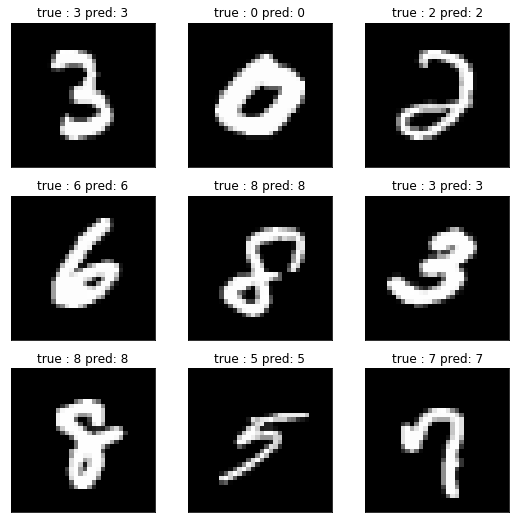

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

loader = DataLoader(dataset=RandomDataset('../data/', 't10k'),
                    batch_size=9,
                    shuffle=True)

for x, y in loader:
    pred = net(x).argmax(dim=1, keepdim=True).numpy()
    
    size = int(np.ceil(x.shape[0] ** 0.5))
    fig, axes = plt.subplots(nrows=size, ncols=size, figsize=(size * 3, size * 3))
    axes = [y for x in axes for y in x]

    for i in range(x.shape[0]):
        axes[i].set_title('true : {} pred: {}'.format(y[i], pred[i][0]))
        axes[i].imshow(x[i, 0, :, :], cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    break